In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [2]:
im1 = cv.imread("boat1.jpg", 0)
im2 = cv.imread("boat3.jpg", 0)

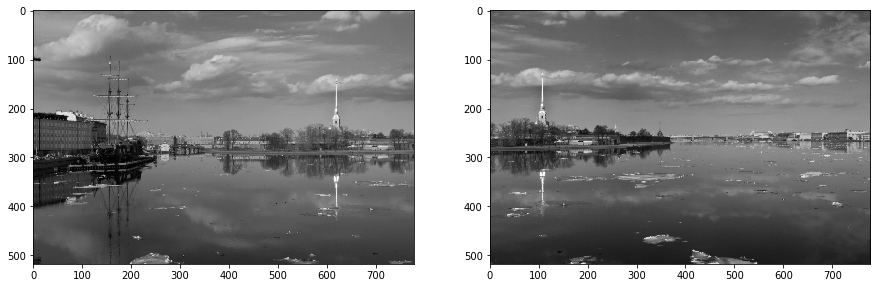

In [3]:
plt.figure(figsize=(15,10))

plt.subplot(121)
plt.imshow(im1, cmap='gray');
plt.subplot(122)
plt.imshow(im2, cmap='gray')

plt.show()

### 1. Trovare l'omografia che descrive la trasformazione tra il <u>secondo</u> set di punti ed il <u>primo</u>

https://docs.opencv.org/3.4.2/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780

In [4]:
# Estrazione keypoint
sift = cv.xfeatures2d.SIFT_create()
(kps1, features1) = sift.detectAndCompute(im1, None)
(kps2, features2) = sift.detectAndCompute(im2, None)
# Match features
bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1, features2)

In [5]:
kps1_matches = list(map(lambda x: x.queryIdx, matches))
kps2_matches = list(map(lambda x: x.trainIdx, matches))

In [6]:
def myHomography(kps1, kps2, matches):
    matches = sorted(matches, key=lambda x: x.distance)[0:100]
    kps1_matches = np.array(list(map(lambda x: kps1[x.queryIdx].pt, matches)))
    kps2_matches = np.array(list(map(lambda x: kps2[x.trainIdx].pt, matches)))
    H,_ = cv.findHomography(kps2_matches, kps1_matches, cv.RANSAC, ransacReprojThreshold=5.0, maxIters=10)
    return H

In [7]:
H = myHomography(kps1, kps2, matches)
print(H)

[[ 5.73690118e-01 -8.51751643e-03  5.21074875e+02]
 [-1.51105651e-01  9.19986997e-01  2.97492435e+01]
 [-5.46450096e-04 -1.49533064e-05  1.00000000e+00]]


### 2. Applicare l'omografia alla seconda immagine

https://docs.opencv.org/3.4.2/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87

https://docs.opencv.org/3.4.2/da/d6e/tutorial_py_geometric_transformations.html

In [54]:
def myWarp(im, H, shape):
    return cv.warpPerspective(im, H, shape)

In [58]:
def transformed_coordinates(H,x,y):
    x_new = (H[0][0]*x+H[0][1]*y+H[0][2])/(H[2][0]*x+H[2][1]*y+H[2][2])
    y_new = (H[1][0]*x+H[1][1]*y+H[1][2])/(H[2][0]*x+H[2][1]*y+H[2][2])
    return x_new, y_new

In [59]:
x_1 = im2.shape[1]
y_1 = im2.shape[0]
print("Transformation of x:", "(" + str(x_1)+"," +str(y_1)+")", "is", transformed_coordinates(H,x_1,y_1))

Transformation of x: (0,518) is (1698.0541761189259, 685.4722892524898)


In [60]:
x_2 = im2.shape[1]
y_2 = 0
print("Transformation of x:", "(" + str(x_2)+"," +str(y_2)+")", "is", transformed_coordinates(H,x_2,y_2))

Transformation of x: (778,0) is (1682.8492421714682, -152.75140791754217)


In [61]:
x_3 = 0
y_3 = 0
print("Transformation of x:", "(" + str(x_3)+"," +str(y_3)+")", "is", transformed_coordinates(H,x_3,y_3))

Transformation of x: (0,0) is (521.0748747468232, 29.74924353681173)


In [62]:
x_4 = 0
y_4 = im2.shape[0]
print("Transformation of x:", "(" + str(x_4)+"," +str(y_4)+")", "is", transformed_coordinates(H,x_4,y_4))

Transformation of x: (0,518) is (520.6960150389759, 510.254846543154)


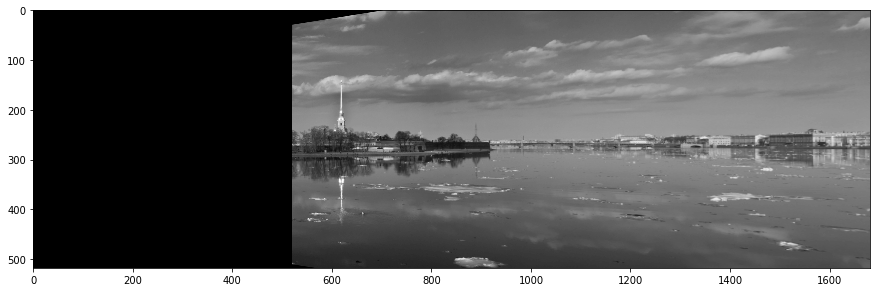

In [71]:
# Apply a perspective warp to stitch the images together
plt.figure(figsize=(15,10))
shape = (int(min(transformed_coordinates(H,x_1,y_1)[0], 
                 transformed_coordinates(H,x_2,y_2)[0])), 
         im2.shape[0])
temp = myWarp(im2, H, shape)
plt.imshow(temp, cmap='gray'); plt.show()

### 3. Integrare la prima immagine

``im_base[from_y:to_y, from_x:to_x] = im_new``

In [50]:
def myCollage(im_base, im_new):
    im_base[:im_new.shape[0],:im_new.shape[1]] = im_new
    return im_base

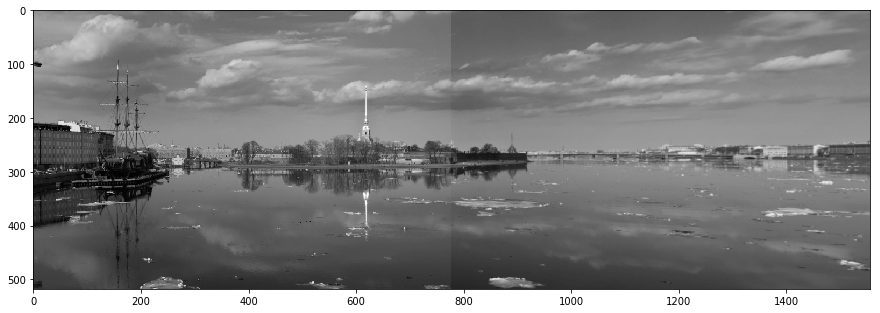

In [11]:
plt.figure(figsize=(15,10))
result = myCollage(temp, im1)
plt.imshow(result, cmap='gray'); plt.show()

### Sticher Funtion to pack everything

In [72]:
def sticher(im1, im2):
    # Estrazione keypoint
    sift = cv.xfeatures2d.SIFT_create()
    (kps1, features1) = sift.detectAndCompute(im1, None)
    (kps2, features2) = sift.detectAndCompute(im2, None)
    # Match features
    bf = cv.BFMatcher(crossCheck=True)
    matches = bf.match(features1, features2)

    kps1_matches = list(map(lambda x: x.queryIdx, matches))
    kps2_matches = list(map(lambda x: x.trainIdx, matches))
    
    H = myHomography(kps1, kps2, matches)
    
    x_1, y_2 = im2.shape[1], im2.shape[0]
    x_2, y_2 = im2.shape[1], 0
    shape = (int(min(transformed_coordinates(H,x_1,y_1)[0], 
                 transformed_coordinates(H,x_2,y_2)[0])), 
         im2.shape[0])
    
    temp = myWarp(im2, H, shape)
    
    return myCollage(temp, im1)

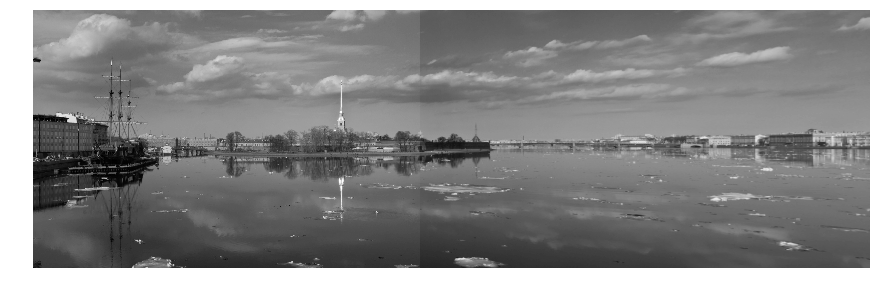

CPU times: user 1.56 s, sys: 133 ms, total: 1.69 s
Wall time: 489 ms


In [79]:
%%time
plt.figure(figsize=(15,10))
plt.imshow(sticher(im1,im2), cmap='gray'); plt.axis('off')
plt.show()

### Smooth Sticher

In [76]:
def myCollage_smooth(im_base, im_new, blend_start):
    #def weight(w):
    #    return (w-blend_start)/(im_new.shape[1]-blend_start)
    im_base[:im_new.shape[0],:blend_start] = im_new[:im_new.shape[0],:blend_start]
    for h in range(im_new.shape[0]):
        for w in range(blend_start,im_new.shape[1]):
            if im_base[h][w]==0:
                im_base[h][w] = im_new[h][w]
            else:
                weight = (w-blend_start)/(im_new.shape[1]-blend_start)
                im_base[h][w] = (1-weight)*im_new[h][w] + weight*im_base[h][w]
    return im_base

def sticher_smooth(im1, im2):
    # Estrazione keypoint
    sift = cv.xfeatures2d.SIFT_create()
    (kps1, features1) = sift.detectAndCompute(im1, None)
    (kps2, features2) = sift.detectAndCompute(im2, None)
    # Match features
    bf = cv.BFMatcher(crossCheck=True)
    matches = bf.match(features1, features2)

    kps1_matches = list(map(lambda x: x.queryIdx, matches))
    kps2_matches = list(map(lambda x: x.trainIdx, matches))
    
    H = myHomography(kps1, kps2, matches)
    
    x_1, y_2 = im2.shape[1], im2.shape[0]
    x_2, y_2 = im2.shape[1], 0
    shape = (int(min(transformed_coordinates(H,x_1,y_1)[0], 
                 transformed_coordinates(H,x_2,y_2)[0])), 
         im2.shape[0])
    temp = myWarp(im2, H, shape)
    
    x_3, y_3 = 0, 0
    x_4, y_4 = im2.shape[1], 0
    blend_start = int(min(transformed_coordinates(H,x_3,y_3)[0], 
                         transformed_coordinates(H,x_4,y_4)[0]))
    return myCollage_smooth(temp, im1, blend_start)

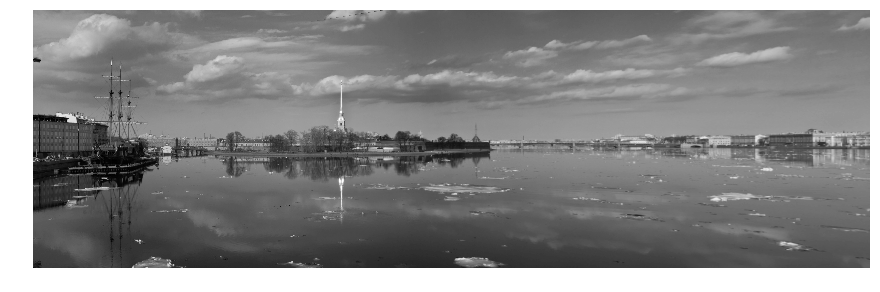

CPU times: user 2.59 s, sys: 78 ms, total: 2.67 s
Wall time: 1.41 s


In [78]:
%%time
plt.figure(figsize=(15,10))
plt.imshow(sticher_smooth(im1,im2), cmap='gray'); plt.axis('off')
plt.show()